In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.ToTensor()

In [4]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
fashion_train = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
fashion_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)


100%|██████████| 9.91M/9.91M [00:11<00:00, 898kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 242kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.43MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.11MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.9MB/s]


In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 input channel → 32 output channels
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32 → 64 output channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # Reduce size by half
            nn.Dropout(0.25)                            # Dropout after conv block
        )

        self.fc = nn.Sequential(
            nn.Flatten(),                               # Flatten for fully connected layer
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.5),                            # Dropout after first FC layer
            nn.Linear(128, 10)                          # Output 10 classes
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

    def extract_features(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return x

In [11]:
# We extract features containing meaningful representations of the image.
# These are collected from the first fully connected layer and will be
# used to produce scatterplots.
# Note: move the tensors to CPU for compatibility with scikit-learn
import numpy as np

def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            feats = model.extract_features(images).cpu().numpy()
            features.append(feats)
            labels.extend(targets.numpy())
    return np.concatenate(features, axis=0), np.array(labels)

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

def plot_feature_projection(model, loader, name="Model"):
    features, labels = extract_features(model, loader, device)

    # using PCA
    pca = PCA(n_components=2)
    features_2d_pca = pca.fit_transform(features)

    # using t-SNE instead
    tsne = TSNE(n_components=2, perplexity=30, init='pca')
    features_2d_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_2d_pca[:, 0], features_2d_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(f'PCA Projection of {name} Features')
    plt.colorbar(scatter, ticks=range(10))
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(f't-SNE Projection of {name} Features')
    plt.colorbar(scatter, ticks=range(10))
    plt.grid(True)
    plt.show()

In [9]:
def train_and_validate(train_dataset, test_dataset, name="mnist"):
    # Split data into train/val
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_data, val_data = random_split(train_dataset, [train_size, val_size])

    batch_size = 64

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = CustomCNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_accuracies = []
    num_epochs = 30

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validate the model after each epoch
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        train_losses.append(running_loss / len(train_loader))
        val_accuracies.append(val_acc)

        print(f"{name.upper()} | Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}")

    torch.save(model.state_dict(), f'customcnn_{name}.pth')

    # plot scatterplots of feature projections
    plot_feature_projection(model, test_loader, name=name)

    # Plot results
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.title(f'Training Loss ({name.upper()})')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.grid(True); plt.legend(); plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
    plt.title(f'Validation Accuracy ({name.upper()})')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.grid(True); plt.legend(); plt.show()


MNIST | Epoch [1/30], Loss: 0.2858, Val Acc: 0.9803
MNIST | Epoch [2/30], Loss: 0.1120, Val Acc: 0.9862
MNIST | Epoch [3/30], Loss: 0.0863, Val Acc: 0.9883
MNIST | Epoch [4/30], Loss: 0.0692, Val Acc: 0.9880
MNIST | Epoch [5/30], Loss: 0.0602, Val Acc: 0.9895
MNIST | Epoch [6/30], Loss: 0.0551, Val Acc: 0.9885
MNIST | Epoch [7/30], Loss: 0.0460, Val Acc: 0.9907
MNIST | Epoch [8/30], Loss: 0.0435, Val Acc: 0.9912
MNIST | Epoch [9/30], Loss: 0.0364, Val Acc: 0.9922
MNIST | Epoch [10/30], Loss: 0.0362, Val Acc: 0.9913
MNIST | Epoch [11/30], Loss: 0.0301, Val Acc: 0.9920
MNIST | Epoch [12/30], Loss: 0.0299, Val Acc: 0.9922
MNIST | Epoch [13/30], Loss: 0.0289, Val Acc: 0.9917
MNIST | Epoch [14/30], Loss: 0.0261, Val Acc: 0.9912
MNIST | Epoch [15/30], Loss: 0.0255, Val Acc: 0.9912
MNIST | Epoch [16/30], Loss: 0.0229, Val Acc: 0.9922
MNIST | Epoch [17/30], Loss: 0.0223, Val Acc: 0.9920
MNIST | Epoch [18/30], Loss: 0.0220, Val Acc: 0.9932
MNIST | Epoch [19/30], Loss: 0.0187, Val Acc: 0.9913
MN

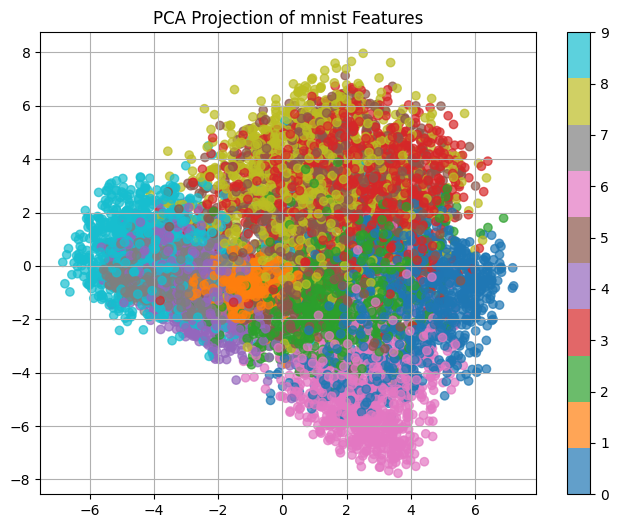

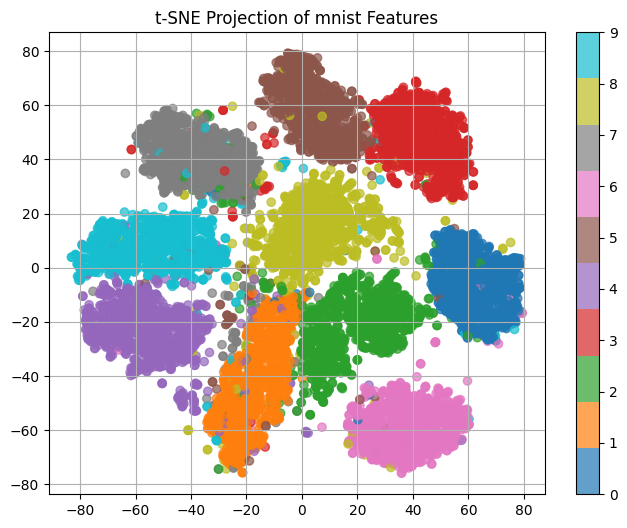

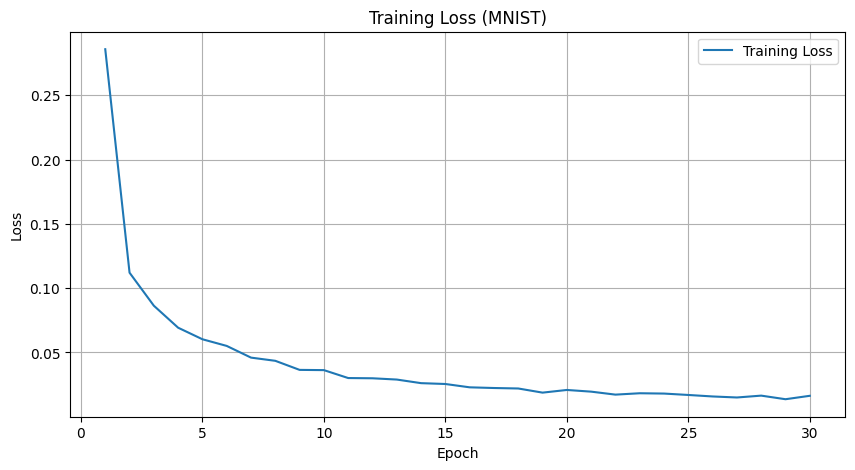

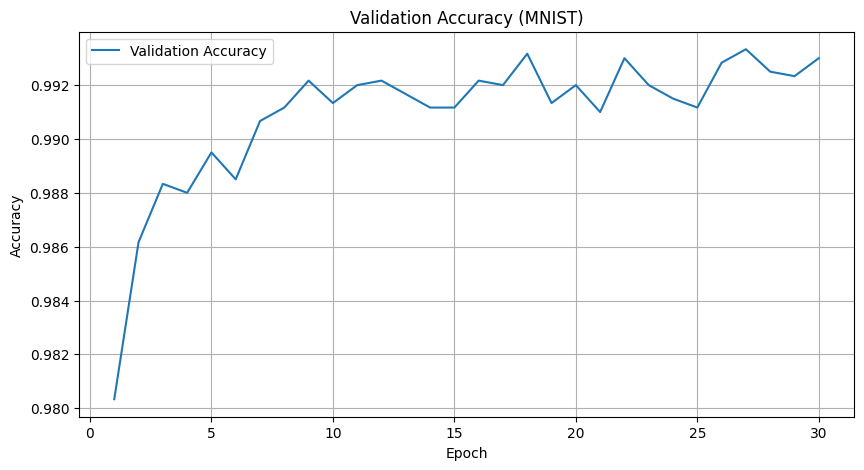

In [16]:
# MNIST dataset train/validate
train_and_validate(mnist_train, mnist_test, name="mnist")

FASHION | Epoch [1/30], Loss: 0.5015, Val Acc: 0.8965
FASHION | Epoch [2/30], Loss: 0.3299, Val Acc: 0.9092
FASHION | Epoch [3/30], Loss: 0.2864, Val Acc: 0.9160
FASHION | Epoch [4/30], Loss: 0.2503, Val Acc: 0.9213
FASHION | Epoch [5/30], Loss: 0.2304, Val Acc: 0.9275
FASHION | Epoch [6/30], Loss: 0.2075, Val Acc: 0.9240
FASHION | Epoch [7/30], Loss: 0.1916, Val Acc: 0.9277
FASHION | Epoch [8/30], Loss: 0.1759, Val Acc: 0.9303
FASHION | Epoch [9/30], Loss: 0.1605, Val Acc: 0.9313
FASHION | Epoch [10/30], Loss: 0.1495, Val Acc: 0.9295
FASHION | Epoch [11/30], Loss: 0.1415, Val Acc: 0.9325
FASHION | Epoch [12/30], Loss: 0.1302, Val Acc: 0.9310
FASHION | Epoch [13/30], Loss: 0.1211, Val Acc: 0.9302
FASHION | Epoch [14/30], Loss: 0.1160, Val Acc: 0.9313
FASHION | Epoch [15/30], Loss: 0.1112, Val Acc: 0.9315
FASHION | Epoch [16/30], Loss: 0.1027, Val Acc: 0.9328
FASHION | Epoch [17/30], Loss: 0.0980, Val Acc: 0.9348
FASHION | Epoch [18/30], Loss: 0.0936, Val Acc: 0.9330
FASHION | Epoch [19

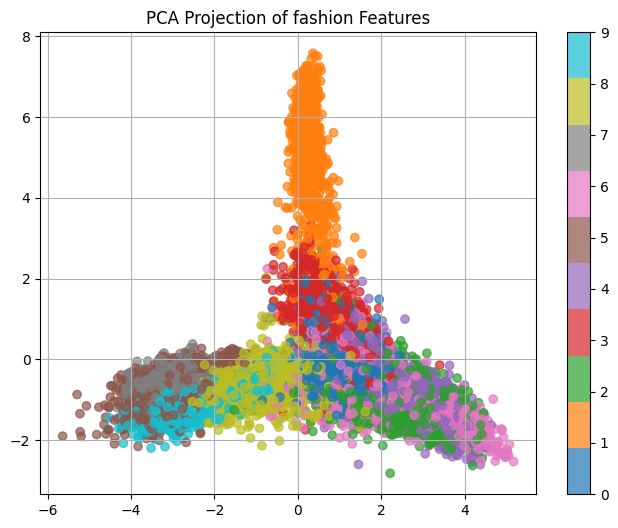

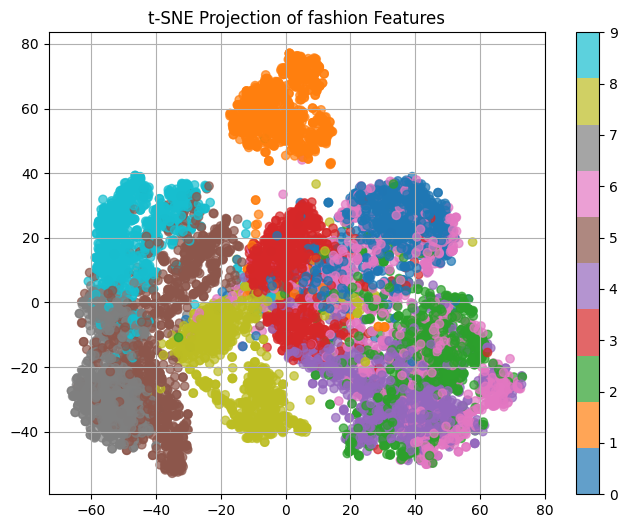

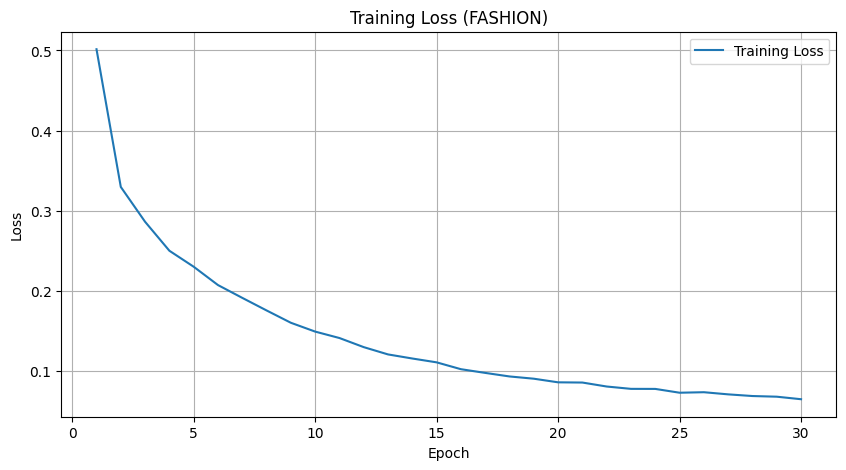

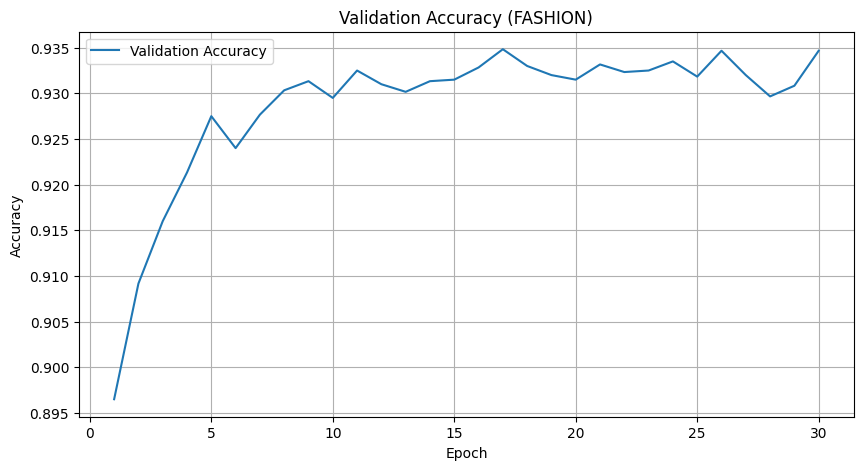

In [17]:
# Fashion-MNIST dataset train/validate
train_and_validate(fashion_train, fashion_test, name="fashion")